In [244]:
import os
import joblib

import pandas as pd
import numpy as np

import re 

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from transformers import BertTokenizerFast, BertForSequenceClassification, AdamW
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [245]:
from preprocessing_utils import preprocess_texts

In [246]:
DATA_PATH = '/data/02_training_data/'
MODEL_OUT_PATH = '/data/03_models/relation_classifier/'

### Load Data

In [247]:
try:
    train_df = pd.read_parquet(os.path.join(DATA_PATH,'temp_train_df.pq'))
    test_df = pd.read_parquet(os.path.join(DATA_PATH,'temp_test_df.pq'))
except FileNotFoundError as e:
    print(e)

In [248]:
print(train_df.shape)
print(train_df.type_of_regulation.value_counts())
train_df.head(2)

(72, 14)
type_of_regulation
antisense inhibitor of           51
regulates (molecular biology)    15
activator of                      6
Name: count, dtype: int64


,srna,srna_synonyms,type_of_regulation,target_gene,quote,quote_from,pmcid,wikidata,srna_name,text_prep,target_gene_id,gene_synonyms,srna_name_mentioned,gene_name_mentioned
0,sRNA encoded by micF,"stc, b4439, ECK2208, IS113, JWR0043, micF",antisense inhibitor of,outer membrane porin F b0929,we suggest that an increased expression of the...,/Article_Viewer%2Ehtml?pmcid=PMC213846&quote=w...,213846,http://www.wikidata.org/entity/Q50418533,micF,we suggest that an increased expression of the...,b0929,"cmlB, cry, ECK0920, nfxB, tolF, ompF",micF,ompF
1,sRNA encoded by ryhB,"b4451, ECK3426, IS176, JWR0219, psrA18, ryhB, ...",antisense inhibitor of,aconitate hydratase 1 b1276,The genes regulated by RyhB include some encod...,/Article_Viewer%2Ehtml?pmcid=PMC1251601&quote=...,1251601,http://www.wikidata.org/entity/Q50419794,ryhB,The genes regulated by RyhB include some encod...,b1276,"acn, ECK1271, acnA",RyhB,"acnA, acn"


In [249]:
print(test_df.shape)
print(test_df.type_of_regulation.value_counts())
test_df.head(2)

(27, 14)
type_of_regulation
antisense inhibitor of           17
regulates (molecular biology)     9
activator of                      1
Name: count, dtype: int64


,srna,srna_synonyms,type_of_regulation,target_gene,quote,quote_from,pmcid,wikidata,srna_name,text_prep,target_gene_id,gene_synonyms,srna_name_mentioned,gene_name_mentioned
0,sRNA encoded by omrB,"t59, b4445, ECK2834, JWR0249, omrB, PAIR2b, rygB",antisense inhibitor of,ferric dihyroxybenzoylserine outer membrane tr...,"Therefore, the first 10 nt of both OmrA and Om...",/Article_Viewer%2Ehtml?pmcid=PMC2588501&quote=...,2588501,http://www.wikidata.org/entity/Q50419398,omrB,Therefore the first 10 nt of both OmrA and Omr...,b2155,"cir, ECK2148, feuA, cirA",OmrB,"cir, cirA"
1,sRNA encoded by omrA,"b4444, ECK2833, JWR0248, omrA, PAIR2a, psrA12,...",antisense inhibitor of,outer membrane protease VII (outer membrane pr...,"Therefore, the first 10 nt of both OmrA and Om...",/Article_Viewer%2Ehtml?pmcid=PMC2588501&quote=...,2588501,http://www.wikidata.org/entity/Q50419343,omrA,Therefore the first 10 nt of both OmrA and Omr...,b0565,"ECK0557, ompT",OmrA,ompT


## Generate negative examples using GPT-4:
**Prompt used:**
> *"Generate 500 sentences that are structured and phrased as if extracted from scientific research articles or academic discussions in the fields of microbiology and molecular biology. These sentences should encompass a broad range of topics including but not limited to gene expression analysis, protein function and interaction, cellular processes, bacterial genetics, and responses to environmental stressors. Each sentence must be unique and present a specific scientific fact, hypothesis, observation, or methodological approach relevant to the aforementioned fields. Ensure the sentences reflect the precision, terminology, and tone typical of scholarly articles, including references to experimental techniques, genetic components, and theoretical frameworks without simulating references or citations. The objective is to create a dataset of negative examples that are contextually similar to discussions about bacterial sRNA regulation but are clearly distinguishable by their lack of specific references to sRNA-mediated regulatory mechanisms."*

In [250]:
from negative_examples import negative_examples
negative_examples = [preprocess_texts(ex) for ex in negative_examples]
len(negative_examples)

500

In [251]:
negative_examples_df = pd.DataFrame(negative_examples, columns=['text_prep'])
negative_examples_df['type_of_regulation'] = 'none'
print(negative_examples_df.shape)
negative_examples_df.head(3)

(500, 2)


,text_prep,type_of_regulation
0,The role of ATP synthase in mitochondrial ener...,none
1,Through chromatin immunoprecipitation assays t...,none
2,The study of bacterial conjugation reveals a h...,none


### Add negative examples to datasets

In [252]:
train_negative_df, test_negative_df =  train_test_split(negative_examples_df, test_size=0.3, random_state=42)

In [253]:
train_df = pd.concat([train_df, train_negative_df])[['text_prep', 'type_of_regulation']].drop_duplicates()
train_df = train_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape, end='\n\n')
print(train_df.type_of_regulation.value_counts())
train_df.head(2)

(374, 2)

type_of_regulation
none                             350
antisense inhibitor of            14
regulates (molecular biology)      7
activator of                       3
Name: count, dtype: int64


,text_prep,type_of_regulation
0,The study of plant microbe interactions provid...,none
1,Understanding the molecular basis of muscle co...,none


In [254]:
test_df = pd.concat([test_df, test_negative_df])[['text_prep', 'type_of_regulation']].drop_duplicates()
test_df = test_df.sample(frac=1).reset_index(drop=True)
print(test_df.shape, end='\n\n')
print(test_df.type_of_regulation.value_counts())
test_df.head(2)

(161, 2)

type_of_regulation
none                             150
antisense inhibitor of             7
regulates (molecular biology)      3
activator of                       1
Name: count, dtype: int64


,text_prep,type_of_regulation
0,The pvdS gene regulating pyoverdine synthesis ...,none
1,Finally the csgDEFG transcript is also subject...,antisense inhibitor of


## Encode Labels

In [255]:
label_encoder = LabelEncoder()
train_df['labels'] = label_encoder.fit_transform(train_df['type_of_regulation'])
test_df['labels'] = label_encoder.fit_transform(test_df['type_of_regulation'])

## Prepare Model Training

In [ ]:
tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.2")

In [ ]:
from torch.utils.data import Dataset
import pandas as pd
import torch

class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=256):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            row['text_prep'],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),  # Remove batch dimension
            'attention_mask': encoding['attention_mask'].squeeze(),  # Remove batch dimension
            'labels': torch.tensor(row['labels'])
        }

In [ ]:
train_dataset = TextDataset(train_df, tokenizer)
test_dataset = TextDataset(test_df, tokenizer)

### Load Model

In [ ]:
num_labels = len(set(train_df["type_of_regulation"]))
model = BertForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2", num_labels=num_labels) 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

## Train Model

In [195]:
from transformers import Trainer, TrainingArguments

# Assuming your dataset is already transformed into a Hugging Face Dataset object named `dataset`
# and split into `train_dataset` and `eval_dataset`

training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=5,             # Total number of training epochs
    per_device_train_batch_size=32,   # Batch size per device during training
    warmup_steps=50,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=50,
    learning_rate=2e-5,
)

trainer = Trainer(
    model=model,                         # The instantiated 🤗 Transformers model to be trained
    args=training_args,                  # Training arguments, defined above
    train_dataset=train_dataset,         # Training dataset
)

# Start the training
trainer.train()


Step,Training Loss
50,0.018300


TrainOutput(global_step=60, training_loss=0.018116316944360732, metrics={'train_runtime': 74.5578, 'train_samples_per_second': 25.081, 'train_steps_per_second': 0.805, 'total_flos': 246013254389760.0, 'train_loss': 0.018116316944360732, 'epoch': 5.0})

## Evaluate Model on Testset

In [196]:
test_result = trainer.predict(test_dataset)

# Extract the logits
logits = test_result.predictions

# Convert logits to probabilities
probabilities = F.softmax(torch.from_numpy(logits), dim=1)
max_probs, predictions = torch.max(probabilities, dim=1)

# You might need to adapt this part based on how your labels are represented
true_labels = [example['labels'].item() for example in test_dataset]

# Convert tensors to numpy arrays for easier handling
predictions_np = predictions.numpy()
max_probs_np = max_probs.numpy()


# Assuming you have a label_encoder or a similar mechanism to convert ids to label names
true_labels_names = label_encoder.inverse_transform(true_labels)
predicted_labels_names = label_encoder.inverse_transform(predictions_np)

# Generate and print the classification report
report = classification_report(true_labels_names, predicted_labels_names, zero_division=1)
print(report)

                               precision    recall  f1-score   support

                 activator of       1.00      0.00      0.00         1
       antisense inhibitor of       1.00      0.86      0.92         7
                         none       0.99      1.00      1.00       150
regulates (molecular biology)       0.75      1.00      0.86         3

                     accuracy                           0.99       161
                    macro avg       0.94      0.71      0.69       161
                 weighted avg       0.99      0.99      0.98       161



<Figure size 1000x1000 with 0 Axes>

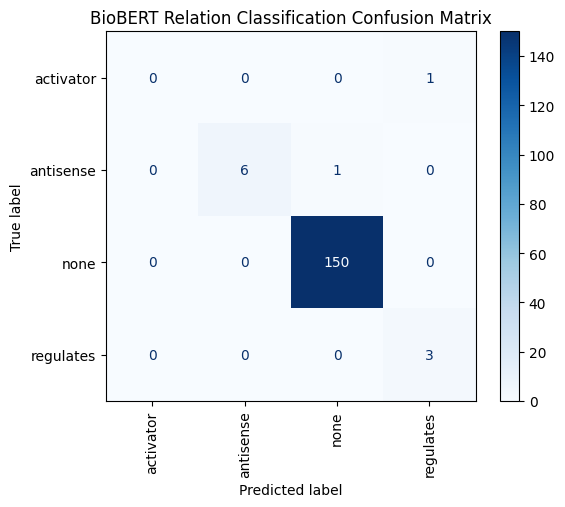

In [197]:
cm = confusion_matrix(true_labels_names, predicted_labels_names, labels=label_encoder.classes_)
# Initialize the ConfusionMatrixDisplay instance with the computed confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[c.split(' ')[0] for c in label_encoder.classes_])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('BioBERT Relation Classification Confusion Matrix')
plt.show()

## RegEx Feature Extraction
### Analyze Term Frequencies

In [200]:
nltk_stop_words = stopwords.words('english')
tfidf_vectorizer = TfidfVectorizer(stop_words=nltk_stop_words)

#### Identify top 30 TFIDF Terms per class

In [201]:
unique_terms_per_class = {}

for label in train_df.type_of_regulation.unique():
    # Vectorize the current class texts
    tfidf_matrix = tfidf_vectorizer.fit_transform(train_df[train_df.type_of_regulation==label].text_prep.to_list())
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Sum tfidf scores for each term across all documents in the class
    sum_tfidf = tfidf_matrix.sum(axis=0)
    tfidf_scores = [(feature_names[col], sum_tfidf[0, col]) for col in range(sum_tfidf.shape[1])]
    
    # Sort the terms by their score and select the top 20
    sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)[:50]
    
    # At this point, you have the top 20 terms for the current class
    # but they are not yet filtered for uniqueness across classes
    unique_terms_per_class[label] = [term for term, score in sorted_tfidf_scores]

    print(f'Top 20 terms for {label}:')
    print(unique_terms_per_class[label])
    print()

Top 20 terms for none:
['bacterial', 'gene', 'mechanisms', 'bacteria', 'microbial', 'role', 'potential', 'environmental', 'study', 'insights', 'understanding', 'production', 'strategies', 'including', 'processes', 'provides', 'application', 'cell', 'resistance', 'synthesis', 'regulation', 'stress', 'response', 'adaptation', 'roles', 'health', 'biosynthesis', 'exploration', 'protein', 'nutrient', 'development', 'energy', 'cycling', 'cellular', 'interactions', 'systems', 'offers', 'crucial', 'compounds', 'environments', 'degradation', 'investigation', 'survival', 'metabolic', 'highlights', 'nitrogen', 'metabolism', 'organic', 'involved', 'informs']

Top 20 terms for antisense inhibitor of:
['rna', 'gcvb', 'expression', 'genes', 'suggest', 'fur', 'targets', 'mrna', 'ryhb', 'srna', 'repressed', 'proteins', 'mutant', 'could', 'mrnas', 'results', 'regulation', 'rela', 'additional', 'omra', 'region', 'repression', 'previously', 'shown', 'regulate', 'also', 'regulated', 'reduced', 'soda', 'ana

#### Identify Terms within the top 30 TFIDF Terms per class, that are not in other classes

In [202]:
final_unique_terms_per_class = {}

for label, terms in unique_terms_per_class.items():
    other_classes_terms = set()
    for other_class, other_terms in unique_terms_per_class.items():
        if other_class != label:
            other_classes_terms.update(other_terms)
    
    # Filter terms that are not in any other class's top 20 list
    unique_terms = [term for term in terms if term not in other_classes_terms]
    final_unique_terms_per_class[label] = unique_terms
    
    print(f'Top terms for {label} that are not in the other classes:')
    print(final_unique_terms_per_class[label])
    print()

Top terms for none that are not in the other classes:
['bacterial', 'gene', 'mechanisms', 'bacteria', 'microbial', 'potential', 'environmental', 'study', 'insights', 'understanding', 'production', 'strategies', 'including', 'processes', 'provides', 'application', 'cell', 'resistance', 'synthesis', 'stress', 'response', 'adaptation', 'roles', 'health', 'biosynthesis', 'exploration', 'protein', 'nutrient', 'development', 'energy', 'cycling', 'cellular', 'systems', 'offers', 'crucial', 'compounds', 'environments', 'degradation', 'investigation', 'survival', 'metabolic', 'highlights', 'nitrogen', 'metabolism', 'organic', 'informs']

Top terms for antisense inhibitor of that are not in the other classes:
['suggest', 'fur', 'targets', 'ryhb', 'srna', 'proteins', 'mutant', 'could', 'mrnas', 'rela', 'additional', 'region', 'repression', 'shown', 'regulate', 'regulated', 'reduced', 'soda', 'analysis', 'dppa', 'gfp', 'oppa', 'encoding', 'transport', '124', '161', 'cyca', 'pairing', 'required', '

### Adjust Predictions based on a RegEx Filter for the 'activator of' class

In [203]:
ner_adjusted_predictions = []
regex_pattern = r"activat(es?|ion|or|ing)"
for i, pred in enumerate(predicted_labels_names):
    if re.search(regex_pattern, test_df['text_prep'].iloc[i]):
        ner_adjusted_predictions.append('activator of')
    else:
        ner_adjusted_predictions.append(pred)

### Adjust Predictions based on a confidence threshold

In [266]:
# Define a confidence threshold
confidence_threshold = 0.6

# Initialize list for predictions adjusted by confidence threshold
confidence_adjusted_predictions = []

for i, (pred, conf) in enumerate(zip(predictions, max_probs)):
    if conf >= confidence_threshold:
        # High confidence: Keep the original prediction
        confidence_adjusted_pred = pred
    else:
        # Low confidence: Assign 'none' class
        confidence_adjusted_pred = 2
    
    confidence_adjusted_predictions.append(confidence_adjusted_pred)
    
confidence_adjusted_predictions_labels_names = label_encoder.inverse_transform(confidence_adjusted_predictions)

## Compare Results

In [267]:
original_report = classification_report(true_labels_names, predicted_labels_names, target_names=label_encoder.classes_, zero_division=True)
regex_report = classification_report(true_labels_names, regex_predicted_labels_names, target_names=label_encoder.classes_, zero_division=True)
threshold_report = classification_report(true_labels_names, confidence_adjusted_predictions_labels_names, target_names=label_encoder.classes_, zero_division=True)

print("Original Prediction Performance:")
print(original_report)
print("\nRegEx Adjusted Prediction Performance:")
print(regex_report)
print("Prediction Performance with Confidence Threshold of 0.6:")
print(threshold_report)

Original Prediction Performance:
                               precision    recall  f1-score   support

                 activator of       1.00      0.00      0.00         1
       antisense inhibitor of       1.00      0.86      0.92         7
                         none       0.99      1.00      1.00       150
regulates (molecular biology)       0.75      1.00      0.86         3

                     accuracy                           0.99       161
                    macro avg       0.94      0.71      0.69       161
                 weighted avg       0.99      0.99      0.98       161


RegEx Adjusted Prediction Performance:
                               precision    recall  f1-score   support

                 activator of       1.00      1.00      1.00         1
       antisense inhibitor of       1.00      0.86      0.92         7
                         none       0.99      1.00      1.00       150
regulates (molecular biology)       1.00      1.00      1.00         3


### Save the finetuned model, tokenizer and labelencoder

In [ ]:
trainer.save_model(MODEL_OUT_PATH)
tokenizer.save_pretrained(MODEL_OUT_PATH)

In [ ]:
joblib.dump(label_encoder, os.path.join(MODEL_OUT_PATH, 'label_encoder.joblib'))